In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('gans-project')
jovian.set_colab_id('1mLYh5unH0r0GkzfsVQRKh_SIp0VUUAQk')

# **Training Generative Adversarial Networks (GANs)**

Deep neural networks are used mainly for supervised learning: classification or regression. Generative Adversarial Networks or GANs, however, use neural networks for a very different purpose: Generative modeling.


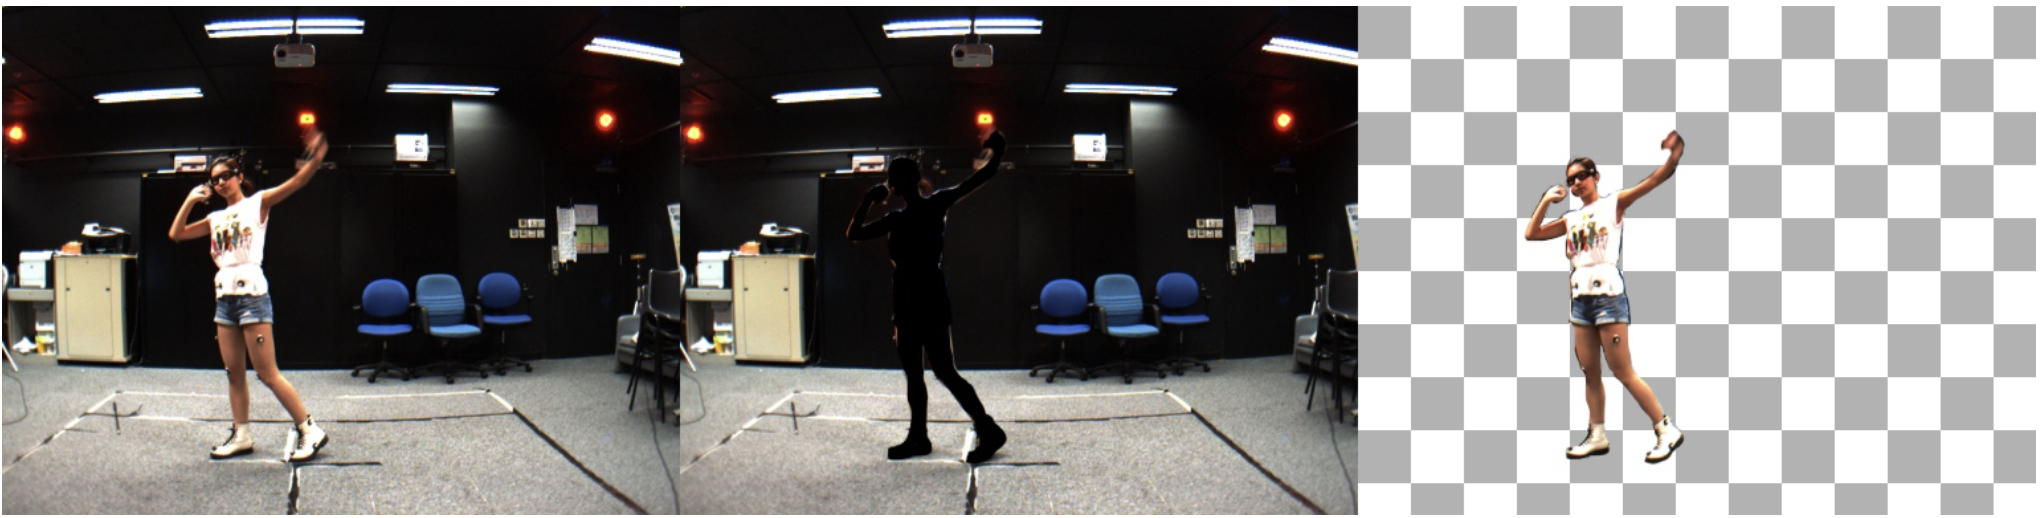

# **Project description**

It's an image data and I will be using GANS in order to automatically discover and learn the regularities or patterns in input data in such a way that the model can be used to fool the discriminator by generating or outputing new examples that plausibly could have been drawn from the original dataset which is a the Martial Arts, Dancing and Sports (MADS). 

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
project_name = 'gans-project'

# **Downloading and Exploring the Data**

In [ ]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od

dataset_url = 'https://www.kaggle.com/tapakah68/segmentation-full-body-mads-dataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: majdoulineaityahia
Your Kaggle Key: ··········


  2%|▏         | 9.00M/474M [00:00<00:08, 59.9MB/s]

100%|██████████| 474M/474M [00:03<00:00, 157MB/s]


In [ ]:
import os

DATA_DIR = './segmentation-full-body-mads-dataset'
print(os.listdir(DATA_DIR))

['segmentation_full_body_mads_dataset_1192_img']


In [ ]:
print(os.listdir(DATA_DIR+'/segmentation_full_body_mads_dataset_1192_img'+'/images')[:10])

['Taichi_S6_C1_00315.png', 'HipHop_HipHop6_C2_00450.png', 'Kata_P3_C2_00405.png', 'Taichi_S4_C1_00675.png', 'Jazz_Jazz5_C0_00540.png', 'HipHop_HipHop6_C2_00765.png', 'Sports_Badminton_C0_00405.png', 'HipHop_HipHop3_C2_00450.png', 'Taichi_S4_C0_00450.png', 'Kata_F4_C0_00360.png']


Let's load this dataset using the ImageFolder class from torchvision. We will also resize and crop the images to 64x64 px, and normalize the pixel values with a mean & standard deviation of 0.5 for each channel. This will ensure that pixel values are in the range (-1, 1), which is more convenient for training the discriminator. We will also create a data loader to load the data in batches.

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

Let's create helper functions to denormalize the image tensors and display some sample images from a training batch.

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

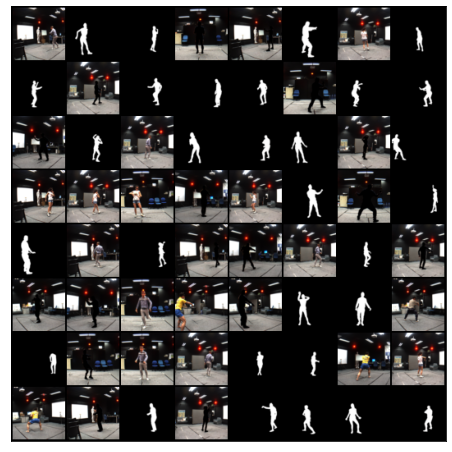

In [ ]:
show_batch(train_dl)

In [ ]:
import jovian

In [ ]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Committed successfully! https://jovian.ai/ninja/gans-project


'https://jovian.ai/ninja/gans-project'

# Using GPU to make it fast

Using the GPU makes the excecution faster than the CPU for large datasets.

we define a couple of helper functions(get_default_device & to_device) and a helper class DeviceDataLoader to move our model & data to the GPU, if one is available.

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

We can now move our training data loader using DeviceDataLoader for automatically transferring batches of data to the GPU (if available).

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

# **Discriminator Network**

The discriminator takes an image as input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network. We'll use a convolutional neural networks (CNN) which outputs a single number output for every image. We'll use stride of 2 to progressively reduce the size of the output feature map.

In [ ]:
import torch.nn as nn

I will use  Leaky ReLU in order to allow the pass of a small gradient signal for negative values. As a result, Instead of passing a gradient (slope) of 0 in the back-prop pass, it passes a small negative gradient. 

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

Just like any other binary classification model, the output of the discriminator is a single number between 0 and 1, which can be interpreted as the probability of the input image being real i.e. picked from the original dataset.

In [ ]:
discriminator = to_device(discriminator, device)

# **Generator Network**

The input to the generator is typically a vector or a matrix of random numbers which is used as a seed for generating an image. The generator will convert a latent tensor of shape (128, 1, 1) into an image tensor of shape 3 x 28 x 28. To achive this, we'll use the ConvTranspose2d layer from PyTorch, which is performs to as a transposed convolution.

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

We observed that using a bounded activation allowed the model to learn more quickly to saturate and cover the color space of the training distribution. Within the discriminator we found the leaky rectified activation (Maas et al., 2013)  to work well, especially for higher resolution modeling.

torch.Size([128, 3, 64, 64])


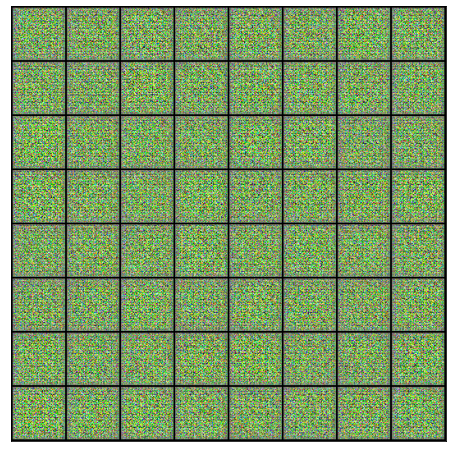

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

# **Discriminator Training**

Since the discriminator is a binary classification model, we can use the binary cross entropy loss function to quantify how well it is able to differentiate between real and generated images.

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

The steps involved in training the discriminator are : 
We expect the discriminator to output 1 if the image was picked from the real MNIST dataset, and 0 if it was generated using the generator network.
We first pass a batch of real images, and compute the loss, setting the target labels to 1.
Then we pass a batch of fake images (generated using the generator) pass them into the discriminator, and compute the loss, setting the target labels to 0.
Finally we add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator.
We don't change the weights of the generator model while training the discriminator.

# Generator Training

Since the outputs of the generator are images, it's not obvious how we can train the generator. This is where we employ a rather elegant trick, which is to use the discriminator as a part of the loss function. Here's how it works:
We generate a batch of images using the generator, pass the into the discriminator.
We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to fool the discriminator.
We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images to fool the discriminator.

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

Let's create a directory where we can save intermediate outputs from the generator to visually inspect the progress of the model. We'll also create a helper function to export the generated images.

In [ ]:
from torchvision.utils import save_image

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

We'll use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model. Let's save one set of images before we start training our model.

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


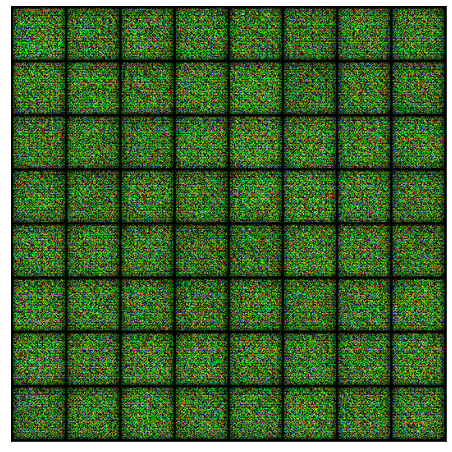

In [ ]:
save_samples(0, fixed_latent)

In [ ]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Committed successfully! https://jovian.ai/ninja/gans-project


'https://jovian.ai/ninja/gans-project'

# **Full Training Loop**

Let's define a fit function to train the discriminator and generator in tandem for each batch of training data. We'll use the Adam optimizer with some custom parameters (betas) that are known to work well for GANs. We will also save some sample generated images at regular intervals for inspection.

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

We are now ready to train the model. We will try different learning rates to see if I can maintain the fine balance between the training the generator and the discriminator.

In [ ]:
lr = 0.0003
epochs = 20

In [ ]:
jovian.reset()
jovian.log_hyperparams(lr=lr, epochs=epochs)

[jovian] Hyperparams logged.


In [ ]:
history = fit(epochs, lr)


Epoch [1/20], loss_g: 4.9327, loss_d: 0.0286, real_score: 0.9757, fake_score: 0.0036
Saving generated-images-0001.png



Epoch [2/20], loss_g: 5.6915, loss_d: 0.6469, real_score: 0.9542, fake_score: 0.2148
Saving generated-images-0002.png



Epoch [3/20], loss_g: 7.7908, loss_d: 0.1257, real_score: 0.9883, fake_score: 0.1025
Saving generated-images-0003.png



Epoch [4/20], loss_g: 3.1402, loss_d: 0.0556, real_score: 0.9601, fake_score: 0.0130
Saving generated-images-0004.png



Epoch [5/20], loss_g: 5.4862, loss_d: 0.0206, real_score: 0.9927, fake_score: 0.0129
Saving generated-images-0005.png



Epoch [6/20], loss_g: 5.2333, loss_d: 0.0214, real_score: 0.9802, fake_score: 0.0010
Saving generated-images-0006.png



Epoch [7/20], loss_g: 6.4762, loss_d: 0.0144, real_score: 0.9907, fake_score: 0.0050
Saving generated-images-0007.png



Epoch [8/20], loss_g: 3.8049, loss_d: 0.2076, real_score: 0.8952, fake_score: 0.0749
Saving generated-images-0008.png



Epoch [9/20], loss_g: 5.9881, loss_d: 0.0614, real_score: 0.9799, fake_score: 0.0378
Saving generated-images-0009.png



Epoch [10/20], loss_g: 6.4954, loss_d: 0.0790, real_score: 0.9580, fake_score: 0.0328
Saving generated-images-0010.png



Epoch [11/20], loss_g: 6.0821, loss_d: 0.0623, real_score: 0.9558, fake_score: 0.0157
Saving generated-images-0011.png



Epoch [12/20], loss_g: 2.0989, loss_d: 0.3770, real_score: 0.7442, fake_score: 0.0065
Saving generated-images-0012.png



Epoch [13/20], loss_g: 4.6189, loss_d: 0.6445, real_score: 0.9452, fake_score: 0.3910
Saving generated-images-0013.png



Epoch [14/20], loss_g: 2.8154, loss_d: 0.0943, real_score: 0.9290, fake_score: 0.0177
Saving generated-images-0014.png



Epoch [15/20], loss_g: 2.4263, loss_d: 0.9989, real_score: 0.5777, fake_score: 0.0058
Saving generated-images-0015.png



Epoch [16/20], loss_g: 3.5051, loss_d: 0.0656, real_score: 0.9536, fake_score: 0.0165
Saving generated-images-0016.png



Epoch [17/20], loss_g: 5.4170, loss_d: 0.0659, real_score: 0.9784, fake_score: 0.0409
Saving generated-images-0017.png



Epoch [18/20], loss_g: 4.7467, loss_d: 0.0963, real_score: 0.9282, fake_score: 0.0119
Saving generated-images-0018.png



Epoch [19/20], loss_g: 4.9036, loss_d: 0.0127, real_score: 0.9918, fake_score: 0.0044
Saving generated-images-0019.png



Epoch [20/20], loss_g: 3.9391, loss_d: 0.0495, real_score: 0.9765, fake_score: 0.0241
Saving generated-images-0020.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
jovian.log_metrics(loss_g=losses_g[-1], 
                   loss_d=losses_d[-1], 
                   real_score=real_scores[-1], 
                   fake_score=fake_scores[-1])

[jovian] Metrics logged.


Now that we have trained the models, we can save checkpoints.

In [ ]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

Here's how the generated images look, after the 1st, 5th and 10th epochs of training.

In [ ]:
from IPython.display import Image

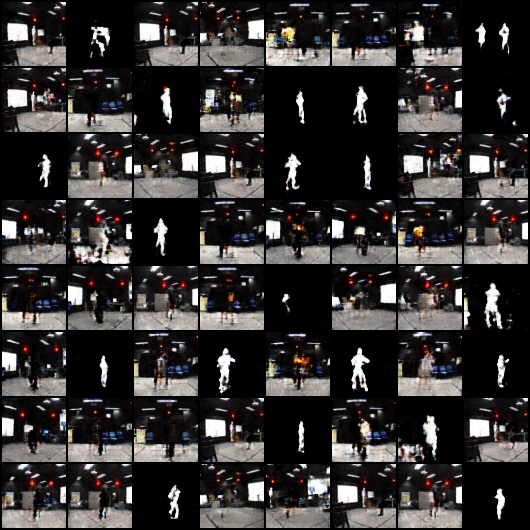

In [ ]:
Image('./generated/generated-images-0001.png')

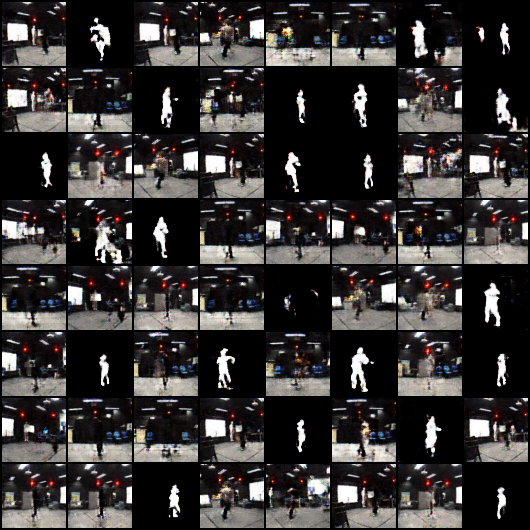

In [ ]:
Image('./generated/generated-images-0005.png')

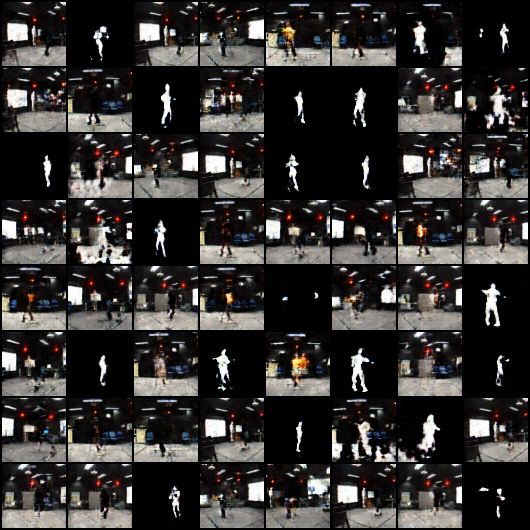

In [ ]:
Image('./generated/generated-images-0010.png')

We can visualize the training process by combining the sample images generated after each epoch into a video using OpenCV.

In [ ]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

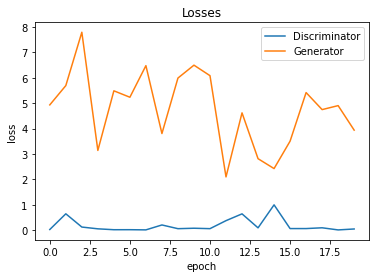

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

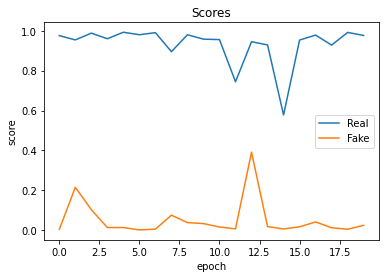

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

# **Save and Commit**

In [ ]:
import jovian

In [ ]:
jovian.commit(project=project_name, 
              outputs=['G.pth', 'D.pth', 'gans_training.avi'], 
              environment=None)

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...


[jovian] Error: Ignoring "G.pth" (not found)
[jovian] Error: Ignoring "D.pth" (not found)
[jovian] Error: Ignoring "gans_training.avi" (not found)


[jovian] Committed successfully! https://jovian.ai/ninja/gans-project


'https://jovian.ai/ninja/gans-project'

# **Conclusions**

It actually took me very long time to find the best choices for the learning rates and number of epochs, also I tried to change the activation functions, all this in order to make the generator loss the lowest possible and having a good discriminator in the same time. It was a good experience because it helped me improve my test skills, try to observe how those two dependant models change in order to find a relation, a pattern and choose the parameters to change in a simple and efficient way.